In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost
!pip install xgboost
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 3.8 MB/s eta 0:00:00


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Number of positive: 30524, number of negative: 1880
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3653
[LightGBM] [Info] Number of data points in the train set: 32404, number of used features: 142
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.941982 -> initscore=2.787241
[LightGBM] [Info] Start training from score 2.787241
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8

Best threshold for F1 score (Class 0): 0.92

Classification Report (wit

<Figure size 1200x800 with 0 Axes>

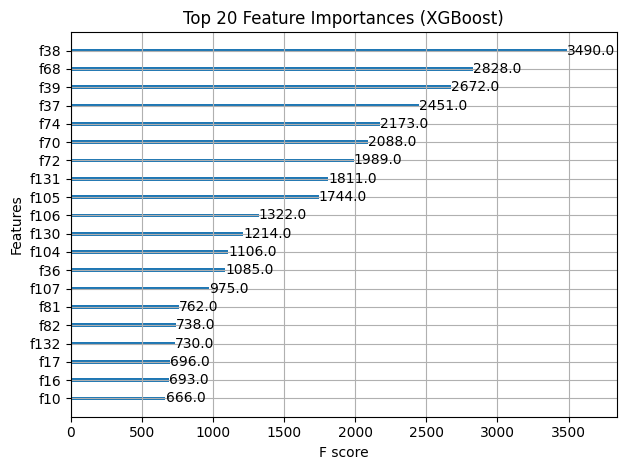

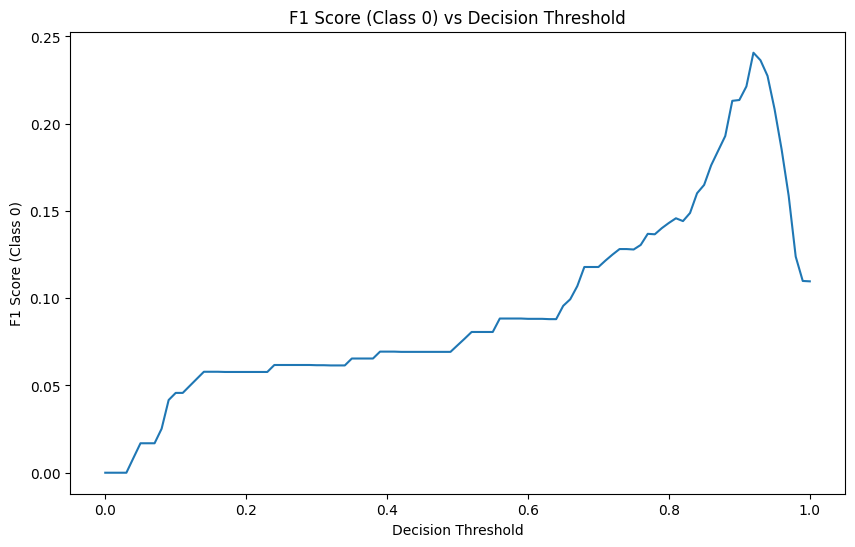

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

SEED = 24

# 데이터셋 로드
df = pd.read_csv('/content/drive/MyDrive/aimers/train.csv')

# 제외할 열 설정
exclude_columns = ["Wip Line_Dam", "Process Desc._Dam",
    "Insp. Seq No._Dam", "Insp Judge Code_Dam",
    "CURE STANDBY POSITION X Collect Result_Dam",
    "CURE STANDBY POSITION Z Collect Result_Dam",
    "CURE STANDBY POSITION Θ Collect Result_Dam",
    "Wip Line_AutoClave", "Process Desc._AutoClave",
    "Equipment_AutoClave", "Workorder_AutoClave",
    "Insp. Seq No._AutoClave", "Insp Judge Code_AutoClave",
    "1st Pressure Judge Value_AutoClave", "2nd Pressure Judge Value_AutoClave",
    "3rd Pressure Judge Value_AutoClave", "GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave",
    "Wip Line_Fill1", "Process Desc._Fill1",
    "Workorder_Fill1", "Workorder_Fill2", "Insp. Seq No._Fill1",
    "Insp Judge Code_Fill1", "Wip Line_Fill2",
    "Process Desc._Fill2", "Model.Suffix_AutoClave",
    "Model.Suffix_Fill1", "Model.Suffix_Fill2",
    "Insp. Seq No._Fill2", "Insp Judge Code_Fill2",
    "CURE END POSITION X Collect Result_Fill2",
    "CURE END POSITION Θ Collect Result_Fill2", "CURE STANDBY POSITION X Collect Result_Fill2",
    "CURE STANDBY POSITION Z Collect Result_Fill2", "CURE STANDBY POSITION Θ Collect Result_Fill2",
    "CURE START POSITION X Collect Result_Fill2", "CURE START POSITION Z Collect Result_Fill2",
    "CURE START POSITION Θ Collect Result_Fill2", "DISCHARGED SPEED OF RESIN Collect Result_Fill2",
    "DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill2", "DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill2",
    "DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill2", "Dispense Volume(Stage1) Collect Result_Fill2",
    "Dispense Volume(Stage2) Collect Result_Fill2", "Dispense Volume(Stage3) Collect Result_Fill2",
    "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam", "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1",
    "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2"]

# 열 제거
df_filtered = df.drop(columns=exclude_columns)

# 1. 값이 없는 열 제거
empty_columns = df_filtered.columns[df_filtered.isnull().all()].tolist()
df_filtered.drop(columns=empty_columns, inplace=True)

# 'Model.Suffix_Dam' 열에 대해 원-핫 인코딩 수행
one_hot_encoded_columns = pd.get_dummies(df_filtered['Model.Suffix_Dam'], dtype=int)

# 원본 데이터에 원-핫 인코딩된 열 추가
df_filtered = df_filtered.drop(columns=['Model.Suffix_Dam'])
df_filtered = pd.concat([df_filtered, one_hot_encoded_columns], axis=1)

# Equipment_Dam
df_filtered['Equipment_Dam'] = df_filtered['Equipment_Dam'].replace({
    'Dam dispenser #1': 0,
    'Dam dispenser #2': 1
})

# 'Equipment_Fill1' 열의 값을 0과 1로 치환
df_filtered['Equipment_Fill1'] = df_filtered['Equipment_Fill1'].replace({
    'Fill1 dispenser #1': 0,
    'Fill1 dispenser #2': 1
})

# Equipment_Fill2
df_filtered['Equipment_Fill2'] = df_filtered['Equipment_Fill2'].replace({
    'Fill2 dispenser #1': 0,
    'Fill2 dispenser #2': 1
})

# 특정 열에 대해 매핑 적용
HEAD_NORMAL_COORDINATE_X_AXIS_X_Stage1 = {np.nan: 0, 'OK': 1}
Chamber_Temp_Judge_Value_AutoClave = {'NG': 0, 'OK': 1}
GMES_ORIGIN_INSP_JUDGE_CODE_Collect_Result_AutoClave = {np.nan: 0, 'OK': 1}
HEAD_NORMAL_COORDINATE_X_AXIS_Stage1_Judge_Value_Fill1 = {np.nan: 0, 'OK': 1}
HEAD_NORMAL_COORDINATE_X_AXIS_Stage1_Judge_Value_Fill2 = {np.nan: 0, 'OK': 1}

df_filtered['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'] = df_filtered['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'].replace(HEAD_NORMAL_COORDINATE_X_AXIS_X_Stage1)
df_filtered['Chamber Temp. Judge Value_AutoClave'] = df_filtered['Chamber Temp. Judge Value_AutoClave'].replace(Chamber_Temp_Judge_Value_AutoClave)
df_filtered['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'] = df_filtered['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].replace(GMES_ORIGIN_INSP_JUDGE_CODE_Collect_Result_AutoClave)
df_filtered['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1'] = df_filtered['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1'].replace(HEAD_NORMAL_COORDINATE_X_AXIS_Stage1_Judge_Value_Fill1)
df_filtered['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2'] = df_filtered['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2'].replace(HEAD_NORMAL_COORDINATE_X_AXIS_Stage1_Judge_Value_Fill2)

# Yeo-Johnson 변환 적용
columns_to_transform = [
    'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
    'CURE END POSITION Z Collect Result_Fill2'
]

pt = PowerTransformer(method='yeo-johnson')
df_filtered[columns_to_transform] = pt.fit_transform(df_filtered[columns_to_transform])

# Workorder_Dam과 target의 관계 계산
workorder_target_relationship = pd.crosstab(df_filtered['Workorder_Dam'], df_filtered['target'])

# 불량 비율 계산
workorder_target_relationship['Abnormal_Percentage'] = (
    workorder_target_relationship['AbNormal'] /
    (workorder_target_relationship['AbNormal'] + workorder_target_relationship['Normal']) * 100
)

# 불량 비율에 따라 내림차순으로 정렬
workorder_target_relationship_sorted = workorder_target_relationship.sort_values(by='Abnormal_Percentage', ascending=False)

# 리스크 등급화를 위한 함수 정의
def categorize_risk(percentage):
    if percentage >= 75:
        return 2  # High Risk
    elif percentage >= 25:
        return 1  # Normal Risk
    else:
        return 0  # Low Risk

# 리스크 카테고리 적용
df_filtered['Risk_Category'] = df_filtered['Workorder_Dam'].map(workorder_target_relationship_sorted['Abnormal_Percentage'].apply(categorize_risk))
df_filtered = df_filtered.drop(columns=['Workorder_Dam'])

# 타겟 변수와 특성 분리
X = df_filtered.drop(columns=['target'])
y = df_filtered['target']

# 타겟 인코딩: 'Normal' -> 1, 'Abnormal' -> 0
y_encoded = y.apply(lambda x: 1 if x == 'Normal' else 0)

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=SEED, stratify=y_encoded)

# 범주형 변수 인코딩
categorical_cols = X_train.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    label_encoders[col] = le

# 동일한 인코더로 테스트 데이터 인코딩
for col in categorical_cols:
    le = label_encoders[col]
    # 테스트 데이터에 학습에 없던 값이 있는지 확인 후 변환
    X_test[col] = X_test[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 모델 설정
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=2,
    scale_pos_weight=10,
    random_state=SEED
)

rf_model = RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=5, min_samples_leaf=2, random_state=SEED)
cb_model = cb.CatBoostClassifier(iterations=500, learning_rate=0.05, depth=8, l2_leaf_reg=5, verbose=0, random_state=SEED)
lgb_model = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.01, num_leaves=31, feature_fraction=0.8, random_state=SEED)

voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_model), ('rf', rf_model), ('cb', cb_model), ('lgb', lgb_model)],
    voting='soft',
    weights=[2, 1, 1, 1]  # XGBoost에 더 높은 가중치 부여
)

# 모델 학습
voting_clf.fit(X_train_scaled, y_train)

# 테스트 세트에 대한 예측
y_prob = voting_clf.predict_proba(X_test_scaled)[:, 1]

# 임계값 조정 (F1 스코어를 고려하여 최적의 임계값 찾기)
thresholds = np.arange(0, 1.01, 0.01)
f1_scores = [f1_score(y_test, (y_prob >= t).astype(int), average='binary', pos_label=0) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]

# 최적 임계값으로 예측
y_pred_optimal = (y_prob >= best_threshold).astype(int)

# 최적 임계값 적용 후 분류 보고서 출력
print(f"\nBest threshold for F1 score (Class 0): {best_threshold:.2f}")
print("\nClassification Report (with Voting Classifier and optimal threshold):")
print(classification_report(y_test, y_pred_optimal))

# XGBoost 모델을 개별적으로 다시 학습하여 특성 중요도 시각화
xgb_model.fit(X_train_scaled, y_train)

# 특성 중요도 시각화 (XGBoost 중요도)
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=20)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

# F1 스코어가 임계값에 따라 어떻게 변하는지 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores)
plt.title("F1 Score (Class 0) vs Decision Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("F1 Score (Class 0)")
plt.show()

13 : 0.25, 0.95, 0.91

In [ ]:
# test_data 로드
test_data = pd.read_csv('/content/drive/MyDrive/aimers/test.csv')

# 1. 불필요한 열 제거
test_data_filtered = test_data.drop(columns=exclude_columns)

# 2. 값이 없는 열 제거
empty_columns_test = test_data_filtered.columns[test_data_filtered.isnull().all()].tolist()
test_data_filtered.drop(columns=empty_columns_test, inplace=True)

# 3. 'Set ID' 열 제거
if 'Set ID' in test_data_filtered.columns:
    test_data_filtered.drop(columns=['Set ID'], inplace=True)

# 4. 'Model.Suffix_Dam' 열에 대해 원-핫 인코딩 수행
one_hot_encoded_columns_test = pd.get_dummies(test_data_filtered['Model.Suffix_Dam'], dtype=int)

# 원본 데이터에 원-핫 인코딩된 열 추가
test_data_filtered = test_data_filtered.drop(columns=['Model.Suffix_Dam'])  # 기존 열 제거
test_data_filtered = pd.concat([test_data_filtered, one_hot_encoded_columns_test], axis=1)

# 5. 특정 열에 대해 매핑 적용
test_data_filtered['Equipment_Dam'] = test_data_filtered['Equipment_Dam'].replace({
    'Dam dispenser #1': 0,
    'Dam dispenser #2': 1
})
test_data_filtered['Equipment_Fill1'] = test_data_filtered['Equipment_Fill1'].replace({
    'Fill1 dispenser #1': 0,
    'Fill1 dispenser #2': 1
})
test_data_filtered['Equipment_Fill2'] = test_data_filtered['Equipment_Fill2'].replace({
    'Fill2 dispenser #1': 0,
    'Fill2 dispenser #2': 1
})

# 6. 다른 열에 대해서도 매핑 적용
test_data_filtered['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'] = test_data_filtered['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'].replace(HEAD_NORMAL_COORDINATE_X_AXIS_X_Stage1)
test_data_filtered['Chamber Temp. Judge Value_AutoClave'] = test_data_filtered['Chamber Temp. Judge Value_AutoClave'].replace(Chamber_Temp_Judge_Value_AutoClave)
test_data_filtered['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'] = test_data_filtered['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].replace(GMES_ORIGIN_INSP_JUDGE_CODE_Collect_Result_AutoClave)
test_data_filtered['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1'] = test_data_filtered['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1'].replace(HEAD_NORMAL_COORDINATE_X_AXIS_Stage1_Judge_Value_Fill1)
test_data_filtered['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2'] = test_data_filtered['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2'].replace(HEAD_NORMAL_COORDINATE_X_AXIS_Stage1_Judge_Value_Fill2)

# 7. Yeo-Johnson 변환 적용
test_data_filtered[columns_to_transform] = pt.transform(test_data_filtered[columns_to_transform])

# 8. 리스크 카테고리 적용
test_data_filtered['Risk_Category'] = test_data_filtered['Workorder_Dam'].map(workorder_target_relationship_sorted['Abnormal_Percentage'].apply(categorize_risk))
test_data_filtered = test_data_filtered.drop(columns=['Workorder_Dam'])

# 9. 범주형 변수 인코딩
for col in categorical_cols:
    le = label_encoders[col]
    test_data_filtered[col] = test_data_filtered[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# 결측치를 0으로 대체
test_data_filtered['Risk_Category'] = test_data_filtered['Risk_Category'].fillna(0)

# 결측치 대체 후 데이터 스케일링
test_data_scaled = scaler.transform(test_data_filtered)

test_data에서 train_data에 없는 Workorder_Dam 값은 하나만 존재: **3G1XC620-2**, 새로운 값이므로 Row Risk로 결정

In [ ]:
# 테스트 데이터에 대한 예측
test_prob = voting_clf.predict_proba(test_data_scaled)[:, 1]

# 최적 임계값으로 예측
test_pred_optimal = (test_prob >= best_threshold).astype(int)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


In [ ]:
sub = pd.DataFrame({
    'Set ID': test_data['Set ID'],
    'target': test_pred_optimal
})
sub['target'] = sub['target'].replace({1: 'Normal', 0: 'AbNormal'})

sub

,Set ID,target
0,0001be084fbc4aaa9d921f39e595961b,Normal
1,0005bbd180064abd99e63f9ed3e1ac80,Normal
2,000948934c4140d883d670adcb609584,Normal
3,000a6bfd02874c6296dc7b2e9c5678a7,Normal
4,0018e78ce91343678716e2ea27a51c95,Normal
...,...,...
17356,ffea508b59934d689b540f95eb3fa730,Normal
17357,ffed8923c8a448a98afc641b770be153,Normal
17358,fff1e73734da40adbe805359b3efb462,Normal
17359,fff8e38bdd09470baf95f71e92075dec,Normal


In [ ]:
# 각 클래스의 개수 계산
class_counts = sub['target'].value_counts()

# 전체 샘플 수
total = len(sub['target'])

# 각 클래스의 비율 계산
class_ratios = class_counts / total

# 결과 출력
print(class_ratios)

target
Normal      0.954726
AbNormal    0.045274
Name: count, dtype: float64


In [ ]:
sub.to_csv('submission.csv', index=False)

**0.18233**

#1